In [67]:
import numpy as np
import time
import math
import modules as md
#import nbodysolver as nbs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

# Newtonian 

In [68]:
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

# Spin 

In [69]:
def accspinorb(r,v,m,ns,S,I):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3))#Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                rucv = np.cross(runi,vrel) 
                rucS = np.cross(runi,S[i])
                vcS = np.cross(vrel,S[i])
                rudv = (runi*vrel).sum()
                a1 = 3*runi*((rucv*S[i]).sum())
                a2 = 2*vcS
                a3 = 3*(rudv)*(rucS)
                a[i] += (1./(c_CU**2))*(2+(3.*m[j]/(2.*m[i])))*(I[i]/rn**3)*(a1 + a2 + a3)
                #a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
    return a # return acceleration

def Jerkspinorb(r,v,m, ns,S):#r,v,m,S,ns #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #Je1[i] += - (3./2)*ns[i]*((m[j])/m[i])*(2*((S*b).sum())*rrel/r**5 ) #Still need to define b 
                Je2[i] += 0 #- (3./2)*ns[i]*((m[j])/m[i])*(Sn**2)*(vrel/rn**5.0 - 5.*((vrel*rrel).sum())*(rrel)/(rn**7.0))               
                Je[i] += Je2[i] #Je1[i] + Je2[i] 
    return Je;

In [70]:
def bccspinorb(r,v,m,ns,S,I): #r position, m mass, s spin, m mass of the star
    b = np.zeros((len(r),3)) #Create acceleration vector
    b1 = np.zeros((len(r),3))
    b2 = np.zeros((len(r),3))
    #bden = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                if(ns[i] == 0.0):
                    b[i] = np.array([0,0,0])
                elif (ns[i] != 0):
                    rrel = r[i]-r[j]
                    rn = ((rrel**2).sum())*(1./2)
                    vrel = v[i] - v[j]
                    mu = m[i]*m[j]/(m[i] + m[j])
                    L = mu*( np.cross(rrel, vrel) )
                    b1[i] += np.cross(L, S[i])#(2 + (3*m[j]/(2*m[i])))*( np.cross(L, S[i]) )*(1/(rn**3.0))
                    #b2[i] += 
                    b[i] = b1[i] #b1[i] #+ b2[i]
    return b # return acceleration

In [71]:
def HermiteUpdatespinbdt(dt, r, v, m, ns, S,I): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspinorb(r,v, m, ns, S,I)
    a = aN + aS           # current acceleration
    aNdot = Jerk(r,v,m)
    aSdot = Jerkspinorb(r, v, m, ns, S)
    adot = aNdot + aSdot # current jerks
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspinorb(rp, vp, m, ns, S,I)
    ap = aNp + aSp         # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspinorb(rp, vp, m, ns, S)
    adotp = aNdotp + aSdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    
    #Spin
    
    b = bccspinorb(r,v,m,ns,S,I) #r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspinorb(rp,vp,m,ns,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc, dtp

In [72]:
def Hermite4thspinbdt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    Iv = np.array([pri.inertiam, sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1],aN_res[:,:,i-1], dtp[i]) = HermiteUpdatespinbdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res, a_res, aN_res, time

In [73]:
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius


Sd = np.array([0.1,0.3])
omega = (Sd*(ns.mass**2))/(ns.inertiam*c_CU)
#nsspinarr = np.array([0,0,ns.sdis/3])
nsspinarr = np.array([0,0,omega[1]])

nsspin = md.Particle("NS",1.2,8.89, nsspinarr)

bh3nsspin = md.Binary(bh3,nsspin, 8*nsspin.radi,0)

In [74]:
tl = 1*bh3nsspin.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.1 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of ti

rSO,vSO,S_SO,b_SO,a_SO,aN_SO,time_SO = Hermite4thspinbdt(bh3,nsspin, bh3nsspin, Nsteps, dt)

print(b_SO[1].T)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [75]:
print(S_SO[1].T)

[[0.         0.         0.01585166]
 [0.         0.         0.01585166]
 [0.         0.         0.01585166]
 ...
 [0.         0.         0.01585166]
 [0.         0.         0.01585166]
 [0.         0.         0.01585166]]


In [76]:
print(b_SO[1].T)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


No handles with labels found to put in legend.


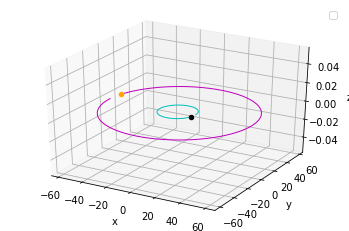

In [77]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rSO[0][0], rSO[0][1], rSO[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rSO[1][0], rSO[1][1], rSO[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rSO[0][0][-1], rSO[0][1][-1], rSO[0][2][-1], 'o', c='black') #s=100
ax.scatter3D(rSO[1][0][-1], rSO[1][1][-1], rSO[1][2][-1], '0', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
#ax.set_ylim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


#plt.savefig('ne-circular2rt-5orbits.eps',bbox_inches='tight')#, dpi=300

plt.show()